In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

## Igor's speedy method...

In [2]:
from __future__ import print_function, absolute_import
from IPython import display
import math
import matplotlib.pyplot as plt
import numpy as np

from multiple_traj_opt import (
    make_mto,
    MultipleTrajOpt,
    initial_conditions_Russ,
    initial_conditions_grid,
    initial_conditions_random,
)
from nn_system.networks import *

In [ ]:
##### RUSS'S MINIBATCH METHOD
from torch.nn.init import * # Here's where I can specify which Torch NN inits I want...

new_mto = None
seed = 1776; np.random.seed(seed); torch.manual_seed(seed)

use_dropout = True
nn_init     = kaiming_uniform # Will this even do anything with warm starting?
nn_noise    = 1e-2
class FCBIG(nn.Module):
    def __init__(self, n_inputs=4, h_sz=32, nn_init=None, nn_noise=0., use_dropout=False):
        self.nn_noise = nn_noise
        self.use_dropout = use_dropout
        super(FCBIG, self).__init__()
        self.n_inputs = n_inputs
        self.fc1 = nn.Linear(self.n_inputs, h_sz)
        self.fc2 = nn.Linear(h_sz, 1)
        
        if use_dropout:
            self.dropout = nn.Dropout(0.5) 
        
        if nn_init is not None:
            nn_init(self.fc1)
            nn_init(self.fc2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        if self.use_dropout:
            x = self.dropout(x)
        x = self.fc2(x)
        x += self.nn_noise # Will this work in Torch?
        return x
    
# Minibatch optimization...
total_iterations = 10
while total_iterations > 0:
    total_iterations -= 1
    ic_list = initial_conditions_random(16, (-math.pi/2, math.pi/2), (-5/2, 5/2)) # Minibatching happening here!
    print(ic_list)
    old_mto, new_mto = method0(new_mto, 
                               ic_list, 
                               kNetConstructor=lambda: FCBIG(),
                               use_constraint=False,
                               cost_factor=.1,
                               vis_cb_every_nth=10, 
                               cost_cb_every_nth=10, 
                               seed=None,
                               snopt_overrides=[('Time limit (secs)',  12.0)])

In [204]:
from traj.vis import (
    plot_trajectory
)
from traj.vi_utils import (do_dircol)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from nn_system.networks import FC, FCBIG, MLPSMALL, MLP
import time

# SUPER HACK - because for some reason you can't keep around a reference to a dircol?
def make_fake_dircol(dircol):
    import copy
    class FakeDircol():
        def __init__(self, dircol):
            self.sample_times     = copy.deepcopy(dircol.GetSampleTimes())
            self.state_samples    = copy.deepcopy(dircol.GetStateSamples())
            self.input_samples    = copy.deepcopy(dircol.GetInputSamples())
#             self.state_trajectory = copy.deepcopy(dircol.ReconstructStateTrajectory())
#             self.input_trajectory = copy.deepcopy(dircol.ReconstructInputTrajectory())
            self.state_trajectory = dircol.ReconstructStateTrajectory()
            self.input_trajectory = dircol.ReconstructInputTrajectory()
        def GetSampleTimes(self):
            return self.sample_times
        def GetStateSamples(self):
            return self.state_samples
        def GetInputSamples(self):
            return self.input_samples
        def ReconstructStateTrajectory(self):
            return self.state_trajectory
        def ReconstructInputTrajectory(self):
            return self.input_trajectory
    return FakeDircol(dircol)

# Absolute bare minimum to get it to work for pendulum, cartpole, and acrobot - THAT'S IT!  Worry about packaging LATER!!!
def igor_traj_opt(ic_list, net, num_samples=32, min_timestep=0.2, max_timestep=0.5):
    optimized_trajs, dircols = [], []
    for i, ic in enumerate(ic_list):
        start = time.time()
        dircol, result = do_dircol(
                            ic           = ic,
                            num_samples  = 32,
                            min_timestep = 0.2,
                            max_timestep = 0.5,
                            warm_start   = "linear",
#                             warm_start = None,
                            seed         = 1776,
                            should_vis   = False)
#         print("{} took {}".format(i, time.time() - start))
#         dircols.append(dircol)
        dircols.append(make_fake_dircol(dircol))

        times   = dircol.GetSampleTimes().T
        x_knots = dircol.GetStateSamples().T
        u_knots = dircol.GetInputSamples().T
        optimized_traj = (times, x_knots, u_knots)
        optimized_trajs.append(optimized_traj)
        if (i+1) % 10 == 0:
            print("completed {} trajectories".format(i+1))
    assert len(optimized_trajs) == len(ic_list)
    return optimized_trajs, dircols


def igor_supervised_learning(trajectories, net, use_prox=True, iter_repeat=1, EPOCHS=1, lr=1e-2):
    alpha, lam, eta = 10, 10**2, 10**-2
    frozen_parameters = [param.clone() for param in net.parameters()]

    criterion1 = nn.MSELoss()
    criterion2 = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    # My data
    all_inputs = np.vstack([np.expand_dims(traj[1], axis=0) for traj in trajectories])
    all_labels = np.vstack([np.expand_dims(traj[2], axis=0) for traj in trajectories])
    all_inputs = all_inputs.reshape(-1, all_inputs.shape[-1])
    all_labels = all_labels.reshape(-1, all_labels.shape[-1])
    print(all_inputs.shape)
    print(all_labels.shape)
    def my_gen():
        for _ in range(iter_repeat):
            yield all_inputs, all_labels

    for epoch in range(EPOCHS):
        running_loss = 0.0
        for i, data in enumerate(my_gen(), 0):
            # Unpack data
            inputs, labels = data
            inputs = torch.tensor(inputs)
            labels = torch.tensor(labels)

            # Forward pass = THE SAUCE!
            outputs = net(inputs)
            loss = alpha/2*criterion1(outputs, labels)
            if use_prox:
                for param, ref in zip(net.parameters(), frozen_parameters):
                    loss += eta/2*criterion2(param, ref)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i+1) % iter_repeat == 0:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    print('Finished Training')

    
def visualize_intermediate_results(trajectories, 
                                   num_trajectories,
                                   num_samples,
                                   network=None, 
                                   ic_list=None,  
                                   ic_scale=1., 
                                   WALLCLOCK_TIME_LIMIT=1,
                                   constructor=lambda: FCBIG(2, 128)):
    vis_ic_list = ic_list
    vis_trajectories = trajectories
    if len(ic_list) > 25:
        print("truncating")
        idcs = np.random.choice(len(ic_list), 25, replace=False)
        vis_ic_list = list((ic_list[idx] for idx in idcs))
        if vis_trajectories:
            vis_trajectories = list((trajectories[idx] for idx in idcs))
        
    plt.figure()
    for (times, x_knots, u_knots) in vis_trajectories:
        plot_trajectory(x_knots.T, "state_scatter", "pendulum", create_figure=False, symbol='-')
    
    if network is not None:
        dummy_mto = MultipleTrajOpt("pendulum", num_trajectories, num_samples, 1, 1)
        dummy_mto.kNetConstructor = constructor # a hack!
        params_list = np.hstack([param.clone().detach().numpy().flatten() for param in network.parameters()])
    
        if vis_ic_list is None:
            vis_ic_list = [x_knots[0] for (_, x_knots, _) in vis_trajectories] # Scary indexing get's first x_knot of each traj.
        for ic in vis_ic_list:
#             h_sol = (0.2+0.5)/2 # TODO: control this better
            h_sol = 0.5
            _, x_knots, _ = dummy_mto._MultipleTrajOpt__rollout_policy_given_params(h_sol, params_list, ic=np.array(ic)*ic_scale, WALLCLOCK_TIME_LIMIT=WALLCLOCK_TIME_LIMIT)
            plot_trajectory(x_knots, "state_scatter", "pendulum", create_figure=False, symbol=':')
    plt.show()
    # Enable this to clear each plot on the next draw() call.
#     display.display(plt.gcf())
#     display.clear_output(wait=True)


In [ ]:
net = FCBIG(2, 128)
# net = MLPSMALL(2)
# net = MLP(2, 16)

##### IGOR'S BLOCK-ALTERNATING METHOD
# Either A) you pick one huge block of initial conditions and stick to them throughout the optimization process
# OR B) Keep bouncing around randomly chosen trajectories? (could be similarly huge or smaller...)
# ^ Let's make the above easily flag switchable!!!

# TODO...
# trajs = igor_traj_opt(ic_list, net)  <- yeah should we think about this now??

# Minibatch optimization... Let's not do any warm starting for Igor's...
# plt.figure()
total_iterations = 1
num_trajectories = 961
while total_iterations > 0:
    total_iterations -= 1
#     ic_list = initial_conditions_grid(num_trajectories, (-math.pi, math.pi), (-5., 5.))
    ic_list = initial_conditions_grid(num_trajectories, (0, 2*math.pi), (-5., 5.))

    # Basically exactly what I have now EXCEPT, DON'T Give the NN parameters to the optimizer!!!!!
    # So, actually might want to solve all the N trajectories in parallel/simultaneously!
    # Just add proximity cost on their change from the last iteration...
    # ^ will this get 
    trajectories = igor_traj_opt(ic_list, net) 
    
    # Will need to have access to the current state of the knot points, here...
    # Then will just do a fitting, (can even add in regularization for, like, free!)
    # With an additional knot penalty term and a proximity cost on difference in parameters from the last iteration...
    igor_supervised_learning(trajectories, net, use_prox=False, iter_repeat=1000, EPOCHS=10, lr=1e-2)
    
    # Is this even needed?
    visualize_intermediate_results(vis_trajectories, network=net, ic_list=vis_ic_list, ic_scale=0.5)
#     visualize_intermediate_results(trajectories)#, network=net, ic_list=ic_list)
    
    

In [185]:
total_iterations = 1
num_trajectories = 50**2
# ic_list = initial_conditions_grid(num_trajectories, (0., 2*math.pi), (-5., 5.))
ic_list = initial_conditions_random(num_trajectories, (0., 2*math.pi), (-5., 5.))

In [186]:
trajectories, dircols = igor_traj_opt(ic_list, net, num_samples=32, min_timestep=0.1, max_timestep=0.5) 

completed 10 trajectories
completed 20 trajectories
completed 30 trajectories
completed 40 trajectories
completed 50 trajectories
completed 60 trajectories
completed 70 trajectories
completed 80 trajectories
completed 90 trajectories
completed 100 trajectories
completed 110 trajectories
completed 120 trajectories
completed 130 trajectories
completed 140 trajectories
completed 150 trajectories
completed 160 trajectories
completed 170 trajectories
completed 180 trajectories
completed 190 trajectories
result=SolutionResult.kIterationLimit
completed 200 trajectories
completed 210 trajectories
completed 220 trajectories
completed 230 trajectories
completed 240 trajectories
completed 250 trajectories
completed 260 trajectories
completed 270 trajectories
completed 280 trajectories
result=SolutionResult.kIterationLimit
completed 290 trajectories
completed 300 trajectories
completed 310 trajectories
completed 320 trajectories
completed 330 trajectories
completed 340 trajectories
completed 350 t

In [205]:
# net = FCBIG(2, 32)
kNetConstructor = lambda: MLP(2, 32, layer_norm=False)
net = kNetConstructor()
igor_supervised_learning(trajectories, net, use_prox=False, iter_repeat=100, EPOCHS=20, lr=2e-2)

(80000, 2)
(80000, 1)
[1,   100] loss: 0.001
[2,   100] loss: 0.001
[3,   100] loss: 0.000
[4,   100] loss: 0.000
[5,   100] loss: 0.000
[6,   100] loss: 0.000
[7,   100] loss: 0.000
[8,   100] loss: 0.000
[9,   100] loss: 0.000
[10,   100] loss: 0.000
[11,   100] loss: 0.000
[12,   100] loss: 0.000
[13,   100] loss: 0.000
[14,   100] loss: 0.000
[15,   100] loss: 0.000
[16,   100] loss: 0.000
[17,   100] loss: 0.000
[18,   100] loss: 0.000
[19,   100] loss: 0.000
[20,   100] loss: 0.000
Finished Training


truncating


<IPython.core.display.Javascript object>


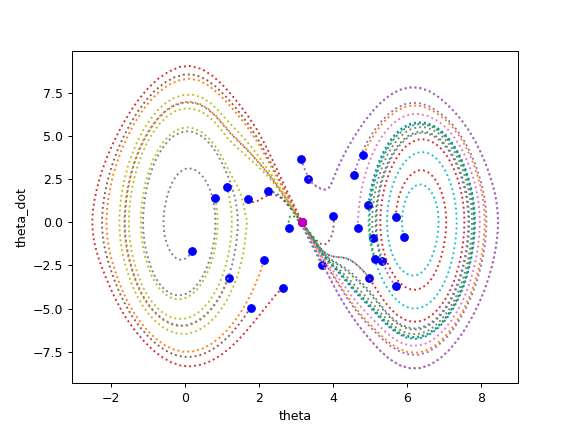

In [189]:
# visualize_intermediate_results(trajectories, 961, 32, network=net, ic_list=ic_list, ic_scale=1., constructor=kNetConstructor, WALLCLOCK_TIME_LIMIT=15)
visualize_intermediate_results([], 2500, 32, network=net, ic_list=ic_list, ic_scale=1., constructor=kNetConstructor, WALLCLOCK_TIME_LIMIT=15)

In [200]:
from pydrake.all import (BarycentricMesh, BarycentricMeshSystem)
def save_vi_policy(vi_policy, name, experiment): # binds to policy and state_grid
    output_values = vi_policy.get_output_values()
    np.save('numpy_saves/pi_b_mesh_init__'+experiment+'_'+name, state_grid)
    np.save('numpy_saves/pi_output_values__'+experiment+'_'+name, output_values)
def load_vi_policy(name, experiment):
    b_mesh_init = np.load('numpy_saves/pi_b_mesh_init__'+experiment+'_'+name+'.npy').tolist()
    output_values = np.load('numpy_saves/pi_output_values__'+experiment+'_'+name+'.npy')
    b_mesh = BarycentricMesh(b_mesh_init)
    return BarycentricMeshSystem(b_mesh, output_values)
def vis_vi_policy(vi_policy):
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm

    sets = vi_policy.get_mesh().get_input_grid()
    lists = [sorted(list(s)) for s in sets]
    [Q, Qdot] = np.meshgrid(*lists)
    Pi = np.reshape(vi_policy.get_output_values(), Q.shape)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel("q")
    ax.set_ylabel("qdot")
    surf = ax.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1,
                            cmap=cm.jet)
def vis_nn_policy_like_vi_policy(net, vi_policy):
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm

    sets = vi_policy.get_mesh().get_input_grid()
    lists = [sorted(list(s)) for s in sets]
    [Q, Qdot] = np.meshgrid(*lists)
    
    coords = zip(Q.flatten(), Qdot.flatten())
    Pi = np.reshape(net.forward(torch.tensor(coords)).data.numpy(), Q.shape)

    fig2 = plt.figure()
    ax2 = fig2.gca(projection='3d')
    ax2.set_xlabel("q")
    ax2.set_ylabel("qdot")
    surf = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1,
                            cmap=cm.jet)
# save_vi_policy(vi_policy, 'good')
# test = load_vi_policy('good')

# Save torch model - https://pytorch.org/tutorials/beginner/saving_loading_models.html
PATH = 'numpy_saves/good_igor_nn_pend_MLP_2_32_no_layer_norm.pt'
torch.save(net.state_dict(), PATH)
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

## Applying to to Pendulum

## Applying to to Cartpole

## Applying to to Acrobot

## Comparison to VI solutions

<IPython.core.display.Javascript object>


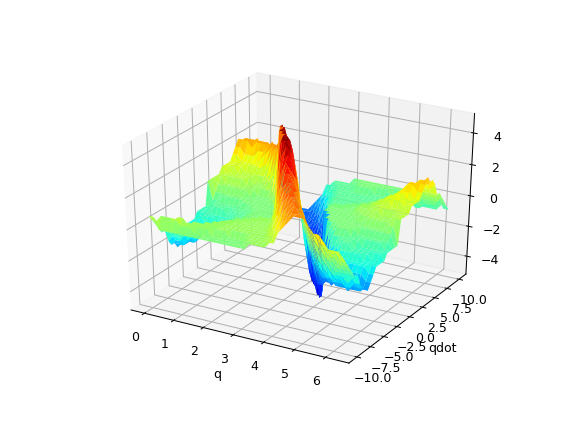

<IPython.core.display.Javascript object>


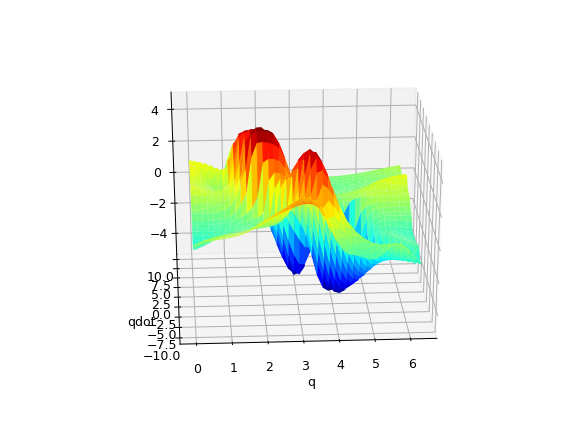

In [206]:
vi_policy = load_policy('good', "pendulum")
vis_vi_policy(vi_policy)
vis_nn_policy_like_vi_policy(net, vi_policy)

In [165]:
dircols[0].ReconstructStateTrajectory()

using_ics=  False
knot_MSE: [13.43466199], traj_MSE: [50.41605436]
[(80000, 2), (80000, 1), (80000, 1)]


<IPython.core.display.Javascript object>


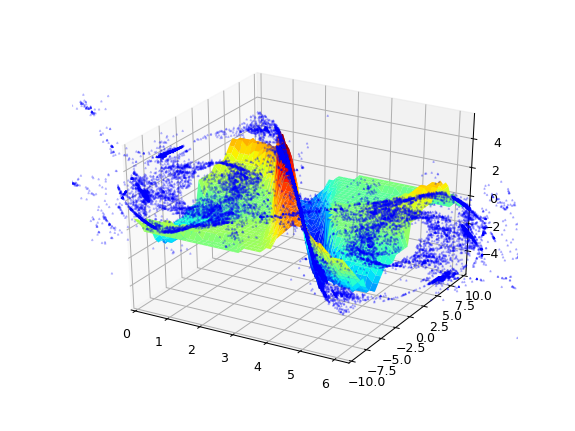

In [201]:
from traj.vi_utils import (graph_vi_policy_vs_traj_knot_scatter)

# ics_or_dircols = ics
ics_or_dircols = dircols
graph_vi_policy_vs_traj_knot_scatter(vi_policy, ics_or_dircols, 
                                     combine_vi_policy_and_scatter=True,
                                     plot_residual=False)